In [1]:
import os
from os.path import join, exists
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, random_split
import numpy as np
import random
import json

#from dataset import Dictionary, VQAFeatureDataset, VisualGenomeFeatureDataset
from dataset_modify import PVQAFeatureDataset, tfidf_from_questions, Dictionary
from dataset_cp_v2 import VQA_cp_Dataset, Image_Feature_Loader
from model.regat import build_regat
from config.parser import parse_with_config
from train import instance_bce_with_logits, compute_score_with_logits, calc_entropy, get_answer, get_target, make_json
import utils
from utils import trim_collate

In [2]:
device = torch.device("cuda")
batch_size = 16
data_folder = './data'

In [3]:
fusion = 'ban'
ban_gamma = 1
mutan_gamma = 2

In [4]:
fusion_methods = fusion+"_"+str(ban_gamma)

In [5]:
dictionary = Dictionary.load_from_file(join(data_folder, 'pvqa/pvqa_dictionary.pkl'))

loading dictionary from ./data\pvqa/pvqa_dictionary.pkl


In [6]:
print(dictionary.idx2word[0:10])
print(f'Length dictionary: {dictionary.ntoken}')

['where', 'are', 'liver', 'stem', 'cells', 'oval', 'located', 'in', 'the', 'canals']
Length dictionary: 4631


## Creating PVQA Dataset

In [7]:
relation_type = 'implicit'
adaptive = False
imp_pos_emb_dim = 64

In [8]:
print("PVQA Feature Dataset's beeing created")
print("\nTraining dataset's beeing created")
train_dset = PVQAFeatureDataset(
                'train', dictionary, relation_type,
                adaptive=adaptive, pos_emb_dim=imp_pos_emb_dim)
train_dset.spatial_adj_matrix = np.ones((3021,36,36))

PVQA Feature Dataset's beeing created

Training dataset's beeing created
Setting semantic adj matrix to None...
Setting spatial adj matrix to None...


In [9]:
print("\nValidation dataset's beeing created")
val_dset = PVQAFeatureDataset(
                'val', dictionary, relation_type, adaptive=adaptive,
                pos_emb_dim=imp_pos_emb_dim)
val_dset.spatial_adj_matrix = np.ones((3021,36,36))
print("\nTest dataset's beeing created")
test_dset = PVQAFeatureDataset(
                'test', dictionary, relation_type,
                adaptive=adaptive, pos_emb_dim=imp_pos_emb_dim)
test_dset.spatial_adj_matrix = np.ones((3021,36,36))


Validation dataset's beeing created
Setting semantic adj matrix to None...
Setting spatial adj matrix to None...

Test dataset's beeing created
Setting semantic adj matrix to None...
Setting spatial adj matrix to None...


### Verifying dimension

In [10]:
train_loader = DataLoader(train_dset, batch_size, shuffle=True, collate_fn=trim_collate)
for i, (v, norm_bb, q, target, _, _, bb, spa_adj_matrix, sem_adj_matrix) in enumerate(train_loader):
    print(spa_adj_matrix.shape)
    print(np.tile(spa_adj_matrix[:,:,:, np.newaxis], [1,1,1,4092]).shape)
    break

torch.Size([16, 36, 36])
(16, 36, 36, 4092)


In [11]:
val_loader = DataLoader(val_dset, batch_size, shuffle=True, collate_fn=trim_collate)
for i, (v, norm_bb, q, target, _, _, bb, spa_adj_matrix, sem_adj_matrix) in enumerate(val_loader):
    print(spa_adj_matrix.shape)
    print(np.tile(spa_adj_matrix[:,:,:, np.newaxis], [1,1,1,4092]).shape)
    break

torch.Size([16, 36, 36])
(16, 36, 36, 4092)


In [12]:
test_loader = DataLoader(test_dset, batch_size, shuffle=True, collate_fn=trim_collate)
for i, (v, norm_bb, q, target, _, _, bb, spa_adj_matrix, sem_adj_matrix) in enumerate(test_loader):
    print(spa_adj_matrix.shape)
    print(np.tile(spa_adj_matrix[:,:,:, np.newaxis], [1,1,1,4092]).shape)
    break

torch.Size([16, 36, 36])
(16, 36, 36, 4092)


In [13]:
print(f'Object in the image and embedding dimension: {train_dset[0][0].shape}')
print(f'Bounding box: {train_dset[0][1].shape}')
print(f'Question length: {train_dset[0][2].shape}')
print(f'Target onehot: {train_dset[0][3].shape}')

Object in the image and embedding dimension: torch.Size([36, 2048])
Bounding box: (36, 4)
Question length: torch.Size([14])
Target onehot: torch.Size([4092])


## Bounding box on the image

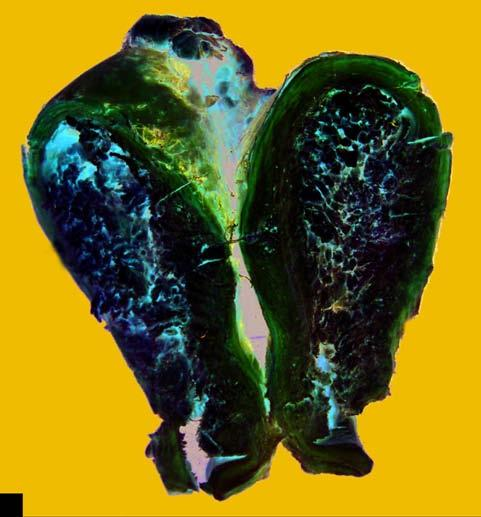

In [14]:
from IPython.display import Image
image_file = 'data/pvqa/images/test/test_0033.jpg'
Image(filename=image_file) 

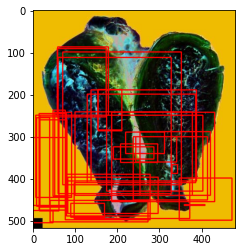

In [15]:
# importing cv2 
import cv2
import matplotlib.pyplot as plt

# Reading an image in default mode
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ret = test_dset[33][1]
bbox = ret.copy()
bbox[:,0] *= image.shape[0]
bbox[:,1] *= image.shape[1]
bbox[:,2] *= image.shape[0]
bbox[:,3] *= image.shape[1]
bbox

   
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = 2

for point in bbox:
    p1 = (round(point[0]), round(point[2]))
    p2 = (round(point[1]), round(point[3]))
    image = cv2.rectangle(image, p1, p2, color, thickness)

plt.imshow(image)
plt.show()

## Building model

In [16]:
from model.fusion import BAN, BUTD, MuTAN
from model.language_model import WordEmbedding, QuestionEmbedding,\
                                 QuestionSelfAttention
from model.relation_encoder import ImplicitRelationEncoder,\
                                   ExplicitRelationEncoder
from model.classifier import SimpleClassifier

In [17]:
op = 'c'
num_hid = 1024
relation_dim = 1024
relation_type = 'spatial'
dir_num = 2
nongt_dim = 20
num_heads = 16
num_steps = 1
residual_connection = True
label_bias = True

In [18]:
class ReGAT(nn.Module):
    def __init__(self, dataset, w_emb, q_emb, q_att, v_relation,
                 joint_embedding, classifier, glimpse, fusion, relation_type):
        super(ReGAT, self).__init__()
        self.name = "ReGAT_%s_%s" % (relation_type, fusion)
        self.relation_type = relation_type
        self.fusion = fusion
        self.dataset = dataset
        self.glimpse = glimpse
        self.w_emb = w_emb
        self.q_emb = q_emb
        self.q_att = q_att
        self.v_relation = v_relation
        self.joint_embedding = joint_embedding
        self.classifier = classifier

    def forward(self, v, b, q, implicit_pos_emb, sem_adj_matrix,
                spa_adj_matrix, labels):
        """Forward
        v: [batch, num_objs, obj_dim]
        b: [batch, num_objs, b_dim]
        q: [batch_size, seq_length]
        pos: [batch_size, num_objs, nongt_dim, emb_dim]
        sem_adj_matrix: [batch_size, num_objs, num_objs, num_edge_labels]
        spa_adj_matrix: [batch_size, num_objs, num_objs, num_edge_labels]

        return: logits, not probs
        """
        w_emb = self.w_emb(q)
        q_emb_seq = self.q_emb.forward_all(w_emb)  # [batch, q_len, q_dim]
        q_emb_self_att = self.q_att(q_emb_seq)

        # [batch_size, num_rois, out_dim]
        if self.relation_type == "semantic":
            v_emb = self.v_relation.forward(v, sem_adj_matrix, q_emb_self_att)
        elif self.relation_type == "spatial":
            v_emb = self.v_relation.forward(v, spa_adj_matrix, q_emb_self_att)
        else:  # implicit
            v_emb = self.v_relation.forward(v, implicit_pos_emb,
                                            q_emb_self_att)

        if self.fusion == "ban":
            joint_emb, att = self.joint_embedding(v_emb, q_emb_seq, b)
        elif self.fusion == "butd":
            q_emb = self.q_emb(w_emb)  # [batch, q_dim]
            joint_emb, att = self.joint_embedding(v_emb, q_emb)
        else:  # mutan
            joint_emb, att = self.joint_embedding(v_emb, q_emb_self_att)
        if self.classifier:
            logits = self.classifier(joint_emb)
        else:
            logits = joint_emb
        return logits, att

In [19]:
def build_regat(dataset, relation_type, fusion, op,  num_hid , relation_dim, dir_num, spa_label_num, imp_pos_emb_dim, nongt_dim, num_heads, num_steps, residual_connection, label_bias, mutan_gamma):
    print("Building ReGAT model with %s relation and %s fusion method" %
          (relation_type, fusion))
    w_emb = WordEmbedding(dataset.dictionary.ntoken, 300, .0, op)
    q_emb = QuestionEmbedding(300 if 'c' not in op else 600,
                              num_hid, 1, False, .0)
    q_att = QuestionSelfAttention(num_hid, .2)

    if relation_type == "spatial":
        v_relation = ExplicitRelationEncoder(
                        dataset.v_dim, num_hid, relation_dim,
                        dir_num, spa_label_num,
                        num_heads=num_heads,
                        num_steps=num_steps, nongt_dim=nongt_dim,
                        residual_connection=residual_connection,
                        label_bias=label_bias)
    else:
        v_relation = ImplicitRelationEncoder(
                        dataset.v_dim, num_hid, relation_dim,
                        dir_num, imp_pos_emb_dim, nongt_dim,
                        num_heads=num_heads, num_steps=num_steps,
                        residual_connection=residual_connection,
                        label_bias = label_bias)

    classifier = SimpleClassifier(num_hid, num_hid * 2,
                                  dataset.num_ans_candidates, 0.5)
    gamma = 0
    if fusion == "ban":
        joint_embedding = BAN(relation_dim, num_hid, ban_gamma)
        gamma = ban_gamma
    elif fusion == "butd":
        joint_embedding = BUTD(relation_dim, num_hid, num_hid)
    else:
        joint_embedding = MuTAN(relation_dim, num_hid,
                                dataset.num_ans_candidates, mutan_gamma)
        gamma = mutan_gamma
        classifier = None
    return ReGAT(dataset, w_emb, q_emb, q_att, v_relation, joint_embedding,
                 classifier, gamma, fusion, relation_type)

In [20]:
model = build_regat(dataset = train_dset, relation_type = relation_type, fusion=fusion, 
                op = op,  num_hid = num_hid , relation_dim = relation_dim, dir_num = dir_num, spa_label_num = 1, 
                imp_pos_emb_dim =  imp_pos_emb_dim, nongt_dim = nongt_dim, num_heads = num_heads, num_steps = num_steps, 
                residual_connection = residual_connection, label_bias= label_bias, mutan_gamma = mutan_gamma).to(device)

Building ReGAT model with spatial relation and ban fusion method
In ExplicitRelationEncoder, num of graph propogation steps: 1, residual_connection: True


# Training

In [21]:
epochs = 20

In [22]:
train_loader = DataLoader(train_dset, batch_size, shuffle=True, collate_fn=trim_collate)
eval_loader = DataLoader(val_dset, batch_size, shuffle=False, collate_fn=trim_collate)
test_loader = DataLoader(train_dset, batch_size, shuffle=True, collate_fn=trim_collate)

In [23]:
output_meta_folder = join('saved_models', "ReGAT_spatial_jup20_%s" % relation_type)
print(output_meta_folder)
utils.create_dir(output_meta_folder)

saved_models\ReGAT_spatial_jup20_spatial


In [24]:
output = output_meta_folder+"/ban_1_implicit_PVQA_20_epochs"
print(output)
utils.create_dir(output)

saved_models\ReGAT_spatial_jup20_spatial/ban_1_implicit_PVQA_20_epochs


In [25]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import json
import numpy as np
import datetime

from dataset_modify import question_types, get_q_type
import utils
from model.position_emb import prepare_graph_variables

In [26]:
def training(model, train_loader, eval_loader, test_loader, 
             epochs, base_lr, lr_decay_start, lr_decay_rate, lr_decay_step, grad_clip,
             weight_decay, output, nongt_dim, imp_pos_emb_dim, spa_label_num, sem_label_num,
             device=torch.device("cuda")):
    N = len(train_loader.dataset)
    lr_default = base_lr
    lr_decay_based_on_val = True
    num_epochs = epochs
    lr_decay_epochs = range(lr_decay_start, num_epochs, lr_decay_step)
    gradual_warmup_steps = [0.5 * lr_default, 1.0 * lr_default,
                            1.5 * lr_default, 2.0 * lr_default]

    optim = torch.optim.Adamax(filter(lambda p: p.requires_grad,
                                      model.parameters()),
                               lr=lr_default, betas=(0.9, 0.999), eps=1e-8,
                               weight_decay=weight_decay) 

    logger = utils.Logger(os.path.join(output, 'log.txt'))
    best_eval_score = 0

    #utils.print_model(model, logger)
    logger.write('optim: adamax lr=%.4f, decay_step=%d, decay_rate=%.2f,'
                 % (lr_default, lr_decay_step, lr_decay_rate) + 'grad_clip=%.2f' % 0.25)
    logger.write('LR decay epochs: '+','.join(
                                        [str(i) for i in lr_decay_epochs]))
    last_eval_score, eval_score = 0, 0
    relation_type = train_loader.dataset.relation_type

    for epoch in range(0, num_epochs):
        total_norm, count_norm = 0, 0
        total_loss, train_score = 0, 0
        count, average_loss, att_entropy = 0, 0, 0
        t = time.time()
        if epoch < len(gradual_warmup_steps):
            for i in range(len(optim.param_groups)):
                optim.param_groups[i]['lr'] = gradual_warmup_steps[epoch]
            logger.write('gradual warmup lr: %.4f' %
                         optim.param_groups[-1]['lr'])
        elif (epoch in lr_decay_epochs or
              eval_score < last_eval_score and lr_decay_based_on_val):
            for i in range(len(optim.param_groups)):
                optim.param_groups[i]['lr'] *= lr_decay_rate
            logger.write('decreased lr: %.4f' % optim.param_groups[-1]['lr'])
        else:
            logger.write('lr: %.4f' % optim.param_groups[-1]['lr'])
        last_eval_score = eval_score

        mini_batch_count = 0
        batch_multiplier = 1
        for i, (v, norm_bb, q, target, _, _, bb, spa_adj_matrix,
                sem_adj_matrix) in enumerate(train_loader):
            batch_size = v.size(0)
            num_objects = v.size(1)
            if mini_batch_count == 0:
                optim.step()
                optim.zero_grad()
                mini_batch_count = batch_multiplier

            v = Variable(v).to(device)
            norm_bb = Variable(norm_bb).to(device)
            q = Variable(q).to(device)
            target = Variable(target).to(device)
            spa_adj_matrix = np.tile(spa_adj_matrix[:,:,:, np.newaxis], [1,1,1,1])
            spa_adj_matrix = torch.from_numpy(spa_adj_matrix)
            spa_adj_matrix = Variable(spa_adj_matrix).to(device)
            
            _, sem_adj_matrix, _ = prepare_graph_variables(
                relation_type, bb, sem_adj_matrix, spa_adj_matrix, num_objects,
                nongt_dim, imp_pos_emb_dim, spa_label_num,
                sem_label_num, device)
            pos_emb = None
            
            pred, att = model(v, norm_bb, q, pos_emb, sem_adj_matrix,
                              spa_adj_matrix, target)
            loss = instance_bce_with_logits(pred, target)

            loss /= batch_multiplier
            loss.backward()
            mini_batch_count -= 1
            total_norm += nn.utils.clip_grad_norm_(model.parameters(),
                                                   grad_clip)
            count_norm += 1
            batch_score = compute_score_with_logits(pred, target, device).sum()
            total_loss += loss.data.item() * batch_multiplier * v.size(0)
            train_score += batch_score

        total_loss /= N
        train_score = 100 * train_score / N
        
        if eval_loader is not None:
            eval_score, bound, entropy = evaluate(model, eval_loader, nongt_dim, imp_pos_emb_dim, spa_label_num, sem_label_num, device)

        logger.write('epoch %d, time: %.2f' % (epoch, time.time()-t))
        logger.write('\ttrain_loss: %.2f, norm: %.4f, score: %.2f'
                     % (total_loss, total_norm / count_norm, train_score))
        
        if eval_loader is not None:
            logger.write('\teval score: %.2f (%.2f)'
                         % (100 * eval_score, 100 * bound))
            if entropy is not None:
                info = ''
                for i in range(entropy.size(0)):
                    info = info + ' %.2f' % entropy[i]
                logger.write('\tentropy: ' + info)
        
        if epoch == num_epochs - 1 and test_loader is not None:
            logger.write('Final epoch %d, time: %.2f, test evaluation' % (epoch, time.time()-t))
            test_score = test_evaluate(model, test_loader, nongt_dim, imp_pos_emb_dim, spa_label_num, sem_label_num, output, 'pvqa', device)
            logger.write('\ttest score: %.2f'
                         % (100 * test_score))
                
                
@torch.no_grad()
def evaluate(model, dataloader, 
             nongt_dim, imp_pos_emb_dim, spa_label_num, sem_label_num, device):
    model.eval()
    relation_type = dataloader.dataset.relation_type
    score = 0
    upper_bound = 0
    num_data = 0
    N = len(dataloader.dataset)
    entropy = None
    if model.fusion == "ban":
        entropy = torch.Tensor(model.glimpse).zero_().to(device)

    for i, (v, norm_bb, q, target, _, _, bb, spa_adj_matrix,
            sem_adj_matrix) in enumerate(dataloader):
        batch_size = v.size(0)
        num_objects = v.size(1)
        v = Variable(v).to(device)
        norm_bb = Variable(norm_bb).to(device)
        q = Variable(q).to(device)
        target = Variable(target).to(device)
        spa_adj_matrix = np.tile(spa_adj_matrix[:,:,:, np.newaxis], [1,1,1,1])
        spa_adj_matrix = torch.from_numpy(spa_adj_matrix)
        spa_adj_matrix = Variable(spa_adj_matrix).to(device)
        _, sem_adj_matrix, _ = prepare_graph_variables(
                relation_type, bb, sem_adj_matrix, spa_adj_matrix, num_objects,
                nongt_dim, imp_pos_emb_dim, spa_label_num,
                sem_label_num, device)
        pos_emb = None
        pred, att = model(v, norm_bb, q, pos_emb, sem_adj_matrix,
                          spa_adj_matrix, target)
        batch_score = compute_score_with_logits(
                        pred, target, device).sum()
        score += batch_score
        upper_bound += (target.max(1)[0]).sum()
        num_data += pred.size(0)
        if att is not None and 0 < model.glimpse\
                and entropy is not None:
            entropy += calc_entropy(att.data)[:model.glimpse]

    score = score / len(dataloader.dataset)
    upper_bound = upper_bound / len(dataloader.dataset)

    if entropy is not None:
        entropy = entropy / len(dataloader.dataset)
    model.train()
    return score, upper_bound, entropy


@torch.no_grad()
def test_evaluate(model, dataloader, nongt_dim, imp_pos_emb_dim, spa_label_num, sem_label_num, output, dataset , device):
    model.eval()
    label2ans = dataloader.dataset.label2ans
    num_answers = len(label2ans)
    relation_type = dataloader.dataset.relation_type
    N = len(dataloader.dataset)
    results = []
    scores = []
    score = 0

    for i, (v, norm_bb, q, target, qid, _, bb, spa_adj_matrix, sem_adj_matrix) in enumerate(dataloader):
        batch_size = v.size(0)
        num_objects = v.size(1)
        v = Variable(v).to(device)
        norm_bb = Variable(norm_bb).to(device)
        q = Variable(q).to(device)
        spa_adj_matrix = np.tile(spa_adj_matrix[:,:,:, np.newaxis], [1,1,1,1])
        spa_adj_matrix = torch.from_numpy(spa_adj_matrix)
        spa_adj_matrix = Variable(spa_adj_matrix).to(device)
        _, sem_adj_matrix, _ = prepare_graph_variables(
                relation_type, bb, sem_adj_matrix, spa_adj_matrix, num_objects,
                nongt_dim, imp_pos_emb_dim, spa_label_num,
                sem_label_num, device)
        pos_emb = None
        pred, att = model(v, norm_bb, q, pos_emb, sem_adj_matrix,
                          spa_adj_matrix, None)

        # Check if target is a placeholder or actual targets
        if target.size(-1) == num_answers:
            target = Variable(target).to(device)
            base_scores = compute_score_with_logits(
                pred, target, device)
            batch_score = base_scores.sum()
            score += batch_score
            scores.append(base_scores.detach().cpu().numpy().sum(-1))
            
        qid = qid.cpu()
        pred = pred.cpu()
        target = target.cpu()
        current_results = make_json(pred, qid, dataloader, target)
        results.extend(current_results)
        results_folder = f"{output}/results"
        utils.create_dir(results_folder)
        save_to = f"{results_folder}/{dataset}.json"
        json.dump(results, open(save_to, "w"))

    scores = np.concatenate(scores).ravel()

    qtype_score = {qtype: 0. for qtype in question_types}
    qtype_cnt = {qtype: 0 for qtype in question_types}
    for i in range(len(dataloader.dataset.entries)):
        entry = dataloader.dataset.entries[i]
        qtype = get_q_type(entry['question'])
        qtype_cnt[qtype] += 1
        qtype_score[qtype] += scores[i]

    with open(os.path.join(output, 'type_result.txt'), 'w') as f:
        info = str(datetime.datetime.now())
        for t in question_types:
            if qtype_cnt[t] > 0:
                info += 'type %s:\tcnt=%d\tacc=%.4f\n' % (t, qtype_cnt[t], qtype_score[t] / qtype_cnt[t])
        f.write(info)
        print(info)

    score = score / N
    return score

In [27]:
training(model, train_loader = train_loader, eval_loader = eval_loader, test_loader = test_loader, 
         epochs = 20, base_lr = 1e-03, lr_decay_start= 15, lr_decay_rate = 0.25, lr_decay_step = 2, grad_clip = 0.25,
         weight_decay = 0, output = output, nongt_dim = nongt_dim, imp_pos_emb_dim = imp_pos_emb_dim, spa_label_num = 0, sem_label_num = 0,
         device=device)

optim: adamax lr=0.0010, decay_step=2, decay_rate=0.25,grad_clip=0.25
LR decay epochs: 15,17,19
gradual warmup lr: 0.0005
epoch 0, time: 115.95
	train_loss: 11.00, norm: 30.9551, score: 40.90
	eval score: 45.12 (100.00)
	entropy:  2.14
gradual warmup lr: 0.0010
epoch 1, time: 121.44
	train_loss: 3.76, norm: 7.8079, score: 45.34
	eval score: 45.31 (100.00)
	entropy:  1.96
gradual warmup lr: 0.0015
epoch 2, time: 124.06
	train_loss: 3.58, norm: 5.9973, score: 47.29
	eval score: 46.87 (100.00)
	entropy:  1.35
gradual warmup lr: 0.0020
epoch 3, time: 125.59
	train_loss: 3.39, norm: 5.0723, score: 48.71
	eval score: 47.75 (100.00)
	entropy:  1.27
lr: 0.0020
epoch 4, time: 127.30
	train_loss: 3.16, norm: 4.0228, score: 51.09
	eval score: 48.08 (100.00)
	entropy:  0.63
lr: 0.0020
epoch 5, time: 127.11
	train_loss: 2.97, norm: 3.4992, score: 53.38
	eval score: 48.48 (100.00)
	entropy:  0.50
lr: 0.0020
epoch 6, time: 128.33
	train_loss: 2.81, norm: 3.5061, score: 55.20
	eval score: 48.91 (100.0